# Billingual Neural Machine Translation on Hindi To English Sentences and Proverbs

# Load Necessary Libraries

In [1]:
import pandas as pd
!pip install kaggle
!pip install kagglehub # Install the necessary package
import kagglehub
import os # Import the 'os' module for file operations

import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Attention, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import torch
from transformers import MarianMTModel, MarianTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint
from nltk.translate.bleu_score import sentence_bleu
from keras.callbacks import ModelCheckpoint


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Data Aquisition

In [2]:
import pandas as pd

# Sample data to begin with 100 rows
data = [

    ["चाँद पर दाग होना", "Every rose has its thorn.", "Even the moon has blemishes."],
    ["सांप की बांबी में हाथ डालना", "To poke the bear.", "Putting your hand in a snake's burrow."],
    ["दिल गार्डन-गार्डन हो गया", "Heart blossomed with joy.", "Heart feels like a blooming garden."],
    ["आग बबूला होना", "To be fuming mad.", "To become a ball of fire."],
    ["समझदार को इशारा काफ़ी है", "A word to the wise is enough.", "A hint is sufficient for the wise."],
    ["पानी-पानी होना", "To feel mortified.", "To feel like melting into water."],
    ["लोहे को लोहा काटता है", "Fight fire with fire.", "Iron cuts iron."],
    ["नाक कटना", "To lose face.", "To have your nose cut off."],
    ["आसमान सिर पर उठाना", "To raise hell.", "To lift the sky on your head."],
    ["गधे को बाप बनाना", "To butter someone up.", "To make a donkey your father."],
    ["जंगल में मोर नाचा किसने देखा", "Unseen work is unappreciated.", "If a peacock dances in the jungle, who sees it?"],
    ["थोथा चना बाजे घना", "Empty vessels make the most noise.", "A hollow grain makes the loudest noise."],
    ["ऊंट के मुंह में जीरा", "A drop in the ocean.", "Cumin seed in a camel's mouth."],
    ["घर का भेदी लंका ढाए", "Traitors destroy from within.", "An insider brought Lanka down."],
    ["हाथी के दांत खाने के और दिखाने के और", "Appearances can be deceiving.", "Elephant's teeth differ for eating and showing."],
    ["आसमान से गिरे, खजूर में अटके", "Out of the frying pan, into the fire.", "Fell from the sky, stuck in a date tree."],
    ["दो नावों की सवारी नहीं हो सकती", "You can’t ride two horses at once.", "One cannot ride two boats."],
    ["डूबते को तिनके का सहारा", "A drowning man catches at a straw.", "A drowning person clings to a straw."],
    ["गिरगिट की तरह रंग बदलना", "To be two-faced.", "To change colors like a chameleon."],
    ["सूरज को दिया दिखाना", "To teach fish to swim.", "Showing a lamp to the sun."],
    ["मुंह में राम, बगल में छुरी", "A wolf in sheep's clothing.", "Ram on the lips, knife by the side."],
    ["नीम हकीम खतरे जान", "A little knowledge is dangerous.", "A half-baked doctor is life-threatening."],
    ["खिसियानी बिल्ली खंभा नोचे", "A guilty mind needs no accuser.", "An embarrassed cat scratches the pillar."],
    ["अंधों में काना राजा", "In the land of the blind, the one-eyed man is king.", "Among the blind, a one-eyed man is king."],
    ["अब पछताए होत क्या जब चिड़िया चुग गई खेत", "It's no use crying over spilt milk.", "Regret after the sparrow has eaten the grain."],
    ["घर की मुर्गी दाल बराबर", "Familiarity breeds contempt.", "Home's chicken is equal to lentils."],
    ["भैंस के आगे बीन बजाना", "Casting pearls before swine.", "Playing the flute in front of a buffalo."],
    ["खुद की ही गली में कुत्ता राजा", "A king only in his own alley.", "A dog rules in his own street."],
    ["दूध का जला छाछ भी फूंक-फूंक कर पीता है", "Once bitten, twice shy.", "A scalded one blows even on buttermilk."],
    ["ऊपर से शेर, अंदर से चूहा", "All bark and no bite.", "A lion outwardly, but a mouse inside."],
    ["जब हाथी चले बाजार, कुत्ते भौंके हजार", "Haters will hate.", "When the elephant walks, a thousand dogs bark."],
    ["सड़क छाप हीरा", "A diamond in the rough.", "A street-found diamond."],
    ["जैसा राजा वैसी प्रजा", "Like king, like subjects.", "As the king, so the people."],
    ["चोर की दाढ़ी में तिनका", "A guilty conscience needs no accuser.", "A thief has a straw in his beard."],
    ["दाने-दाने पर लिखा है खाने वाले का नाम", "What's meant to be will be.", "Every grain is marked with the eater's name."],
    ["हाथ में लड्डू, मुंह में पानी", "Desire but no action.", "Laddoo in hand, water in the mouth."],
    ["खग ही खग को जाने", "Birds of a feather flock together.", "A bird knows another bird."],
    ["सात खून माफ", "All sins are forgiven.", "Seven murders are pardoned."],
    ["नाच न जाने आंगन टेढ़ा", "A bad workman blames his tools.", "Can't dance but blames the courtyard."],
    ["जितने मुंह उतनी बातें", "Too many cooks spoil the broth.", "As many mouths, so many words."],
    ["चोर-चोर मौसेरे भाई", "Thieves recognize their kind.", "A thief and another are cousins."],
    ["गागर में सागर", "Ocean in a pot.", "Profound wisdom in a small package."],
    ["रस्सी जल गई पर बल नहीं गया", "Old habits die hard.", "The rope burned but the twists remain."],
    ["धोबी का कुत्ता, न घर का न घाट का", "A jack of all trades but master of none.", "A washerman's dog, belonging neither to home nor the riverbank."],
    ["जैसी करनी वैसी भरनी", "You reap what you sow.", "As you act, so you shall pay."],
    ["अंधा क्या चाहे, दो आंखें", "The blind desire sight.", "What does a blind person want? Two eyes."],
    ["उंगलियों पर नचाना", "To have someone wrapped around your finger.", "To make someone dance on your fingers."],
    ["अंगूर खट्टे हैं", "Sour grapes.", "The grapes are sour."],
    ["बंदर क्या जाने अदरक का स्वाद", "Ignorance of value.", "What does a monkey know of ginger's taste?"],
    ["सास भी कभी बहू थी", "Every mother-in-law was once a daughter-in-law.", "The mother-in-law was once a daughter-in-law herself."],
    ["सिर मुंडाते ही ओले पड़ना", "When it rains, it pours.", "Hailstones fall as soon as you shave your head."],
    ["ऊंची दुकान फीके पकवान", "All show and no substance.", "Tall shop, tasteless food."],
    ["नौ दिन चले अढ़ाई कोस", "Slow progress.", "Nine days' journey covers just two and a half miles."],
    ["दोस्त का दुश्मन, दुश्मन का दोस्त", "Frenemy.", "A friend's enemy is an enemy's friend."],
    ["एक मछली सारे तालाब को गंदा करती है", "One bad apple spoils the barrel.", "One fish spoils the entire pond."],
    ["अंधे के हाथ बटेर लगना", "Beginner's luck.", "A blind man finds a quail."],
    ["चट मंगनी पट ब्याह", "Quick to act.", "Instant engagement, instant marriage."],
    ["खुदा जब देता है तो छप्पर फाड़ के देता है", "When it rains, it pours (positively).", "When God gives, he breaks the roof."],
    ["लाठी टूट गई मगर सांप नहीं मरा", "Failed effort.", "The stick broke, but the snake did not die."],
    ["आधी छोड़ पूरी को जाए, आधी रहे न पूरी पाए", "Don't bite off more than you can chew.", "Leave the half for the whole, end up with neither."],
    ["जो गरजते हैं वो बरसते नहीं", "Empty threats.", "Those who thunder don't rain."],
    ["दूर के ढोल सुहावने लगते हैं", "The grass is greener on the other side.", "Drums from afar sound sweeter."],
    ["घर में नहीं दाने, अम्मा चली भुनाने", "Living beyond one's means.", "No grains at home, yet mother goes to roast them."],
    ["मन चंगा तो कठौती में गंगा", "Happiness comes from within.", "If the mind is pure, the Ganges flows in a bowl."],
    ["एक तीर से दो शिकार", "Kill two birds with one stone.", "Two hunts with one arrow."],
    ["चोर के पैर नहीं होते", "Liars have no foundation.", "A thief has no legs."],
    ["जाके पांव न फटे बिवाई, वो क्या जाने पीर पराई", "You can’t understand someone’s pain unless you've experienced it.", "He whose feet haven’t cracked can’t understand the pain of others."],
    ["जो बोया वो काटा", "As you sow, so shall you reap.", "What you sow is what you reap."],
    ["जिस थाली में खाया, उसी में छेद किया", "To bite the hand that feeds you.", "Piercing the plate you eat from."],
    ["चिराग तले अंधेरा", "Blind to what's close.", "Darkness under the lamp."],
    ["ऊंट पहाड़ के नीचे आता है", "Everyone meets their match.", "The camel comes under the mountain."],
    ["जो लहरों से टकराए वो ही सिकंदर कहलाए", "No risk, no reward.", "Only those who face the waves are called champions."],
    ["नानी याद दिलाना", "To make someone suffer.", "To remind someone of their grandmother."],
    ["धूल झोंकना", "To deceive someone.", "To throw dust in someone’s eyes."],
    ["सांप भी मर जाए और लाठी भी न टूटे", "To solve a problem without loss.", "The snake should die, but the stick should not break."],
    ["जिसकी लाठी उसकी भैंस", "Might makes right.", "The buffalo belongs to the one with the stick."],
    ["बंदर के हाथ में नारियल", "Incapable person handling something valuable.", "A coconut in a monkey’s hand."],
    ["आटे दाल का भाव पता चलना", "To understand the struggle.", "Realizing the cost of flour and lentils."],
    ["खाली बर्तन ज़्यादा शोर करता है", "Empty vessels make the most noise.", "An empty vessel makes more noise."],
    ["धूप में बाल सफेद नहीं किए हैं", "Not born yesterday.", "Haven't turned my hair white under the sun."],
    ["खिसक गई जमीन", "To lose control.", "The ground slipped away."],
    ["अंधा बांटे रेवड़ी, अपने-अपने को दे", "Favoritism.", "A blind man distributing sweets gives them only to his own."],
    ["अपनी गली में कुत्ता भी शेर होता है", "Confidence in familiar territory.", "Even a dog is a lion in his own alley."],
    ["कोई चोटी पर, कोई खाई में", "Uneven outcomes.", "Some on the peak, some in the valley."],
    ["चावल के दाने में से हांडी का हाल मालूम पड़ता है", "Sample reveals the whole.", "One grain of rice shows the state of the pot."],
    ["कहां राजा भोज, कहां गंगू तेली", "Big difference in status.", "Where is King Bhoj, where is Gangoo the oilman?"],
    ["अब ऊंट पहाड़ के नीचे है", "Justice is served.", "Now the camel is under the mountain."],
    ["चार दिन की चांदनी फिर अंधेरी रात", "Short-lived glory.", "Four days of moonlight, then a dark night."],
    ["गधे को घोड़ा बनाने की कोशिश", "Trying to make the impossible happen.", "Trying to turn a donkey into a horse."],
    ["अंधा क्या चाहे, दो आंखें", "Obvious desires.", "What does a blind man want? Two eyes."],
    ["चालाकी से शेर मारा जाता है", "Strategy over brute strength.", "A lion is killed with cleverness."],
    ["जब जागो तब सवेरा", "It’s never too late.", "Whenever you wake up, it’s morning."],
    ["गड़े मुर्दे उखाड़ना", "To dig up old issues.", "To exhume buried corpses."],
    ["दूर का ढोल सुहाना लगता है", "Something distant seems appealing.", "The drum in the distance sounds pleasing."],
    ["नीचे से फिट और ऊपर से हिट", "Deceptively weak but impactful.", "Fits below, hits above."],
    ["दूसरों की गलती गिनना", "To nitpick others.", "Counting others’ mistakes."],
    ["किसी के हाथ-पैर फूल जाना", "To get flustered.", "Hands and feet swell up."],
    ["एक चुप, सौ सुख", "Silence is golden.", "One silence, a hundred joys."],
    ["ढोल की पोल खोलना", "To expose the truth.", "To reveal the truth about the drum."],
    ["ऊंट के मुंह में जीरा", "Insufficient for needs.", "Cumin in the camel's mouth."]

]
# Creating a DataFrame
columns = ["Hindi Metaphor", "English Translation", "Literal Meaning"]
df = pd.DataFrame(data, columns=columns)

print("The shape of dataset is: ",df.shape)
print("First 5 rows of the dataset:")
df.head(5)

df.to_csv("hindi_english_parallel.csv", index=False)

The shape of dataset is:  (100, 3)
First 5 rows of the dataset:


In [3]:
# Download latest version
path = kagglehub.dataset_download("vaibhavkumar11/hindi-english-parallel-corpus")

print("Path to dataset files:", path)

dataset_path = "/root/.cache/kagglehub/datasets/vaibhavkumar11/hindi-english-parallel-corpus/versions/1"
print("Files in dataset:", os.listdir(dataset_path))

csv_file = os.path.join(dataset_path, "hindi_english_parallel.csv")

# Load the CSV file
df_2 = pd.read_csv(csv_file)

# Display the first few rows
print(df_2.head(5))


100%|██████████| 112M/112M [00:02<00:00, 41.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vaibhavkumar11/hindi-english-parallel-corpus/versions/1
Files in dataset: ['hindi_english_parallel.csv']
                                               hindi  \
0    अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें   
1                    एक्सेर्साइसर पहुंचनीयता अन्वेषक   
2              निचले पटल के लिए डिफोल्ट प्लग-इन खाका   
3               ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका   
4  उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...   

                                          english  
0  Give your application an accessibility workout  
1               Accerciser Accessibility Explorer  
2  The default plugin layout for the bottom panel  
3     The default plugin layout for the top panel  
4  A list of plugins that are disabled by default  


In [4]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1561841 entries, 0 to 1561840
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   hindi    1555784 non-null  object
 1   english  1560964 non-null  object
dtypes: object(2)
memory usage: 23.8+ MB


In [5]:
# Append df_2 into df and rename columns
df_combined = pd.concat([
    df,
    df_2.rename(columns={"hindi": "Hindi Metaphor", "english": "English Translation"})
], ignore_index=True)

# Display the result
print(df_combined.tail(5))

                                            Hindi Metaphor  \
1561936  स्पष्टीकरण.–जहां इस उपधारा के अधीन हानि और लाभ...   
1561937  मैंने गौर किया है कि यह न केवल अपने महत्त्वपूर...   
1561938  उन्होंने मेरे समक्ष जो प्रदर्शन किया उसमें से ...   
1561939  खाद्य और जल सुरक्षा; पर्यावरण की दृष्टि से वहन...   
1561940                                                NaN   

                                       English Translation Literal Meaning  
1561936  स्पष्टीकरण.–जहां इस उपधारा के अधीन हानि और लाभ...             NaN  
1561937  है। I note that this is a landmark meeting – n...             NaN  
1561938  है। In the presentations that they made before...             NaN  
1561939  ्त है। Issues such as food and water security;...             NaN  
1561940                                                NaN             NaN  


# Data Pre-processing

In [6]:
df = df_combined.iloc[:10000].copy()
df = df.drop("Literal Meaning", axis=1)

df.tail(5)

,Hindi Metaphor,English Translation
9995,चीनी (सरल),Chinese Simplified
9996,ज्यॉर्जियाई,Georgian
9997,साइरिलिक/यूक्रेनी,Cyrillic / Ukrainian
9998,विएतनामी,Vietnamese
9999,थाई,Thai


In [7]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [8]:
df.shape

(3532, 2)

This means that there are no duplicate values in our data. Perfect!

In [9]:
# Convert to lowercase
def to_lowercase(text):
    return text.lower()

# Remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# Tokenization
def tokenize(text):
    return word_tokenize(text)

# Remove stopwords
def remove_stopwords(tokens, lang='english'):
    stop_words = set(stopwords.words(lang))
    return [word for word in tokens if word not in stop_words]

# Lemmatization
lemmatizer = WordNetLemmatizer()
def lemmatize(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

In [10]:
# Apply preprocessing
df['Hindi Metaphor Cleaned'] = df['Hindi Metaphor'].apply(to_lowercase).apply(remove_punctuation)
df['English Translation Cleaned'] = df['English Translation'].apply(to_lowercase).apply(remove_punctuation)

df['English Tokens'] = df['English Translation Cleaned'].apply(tokenize)
df['Hindi Tokens'] = df['Hindi Metaphor Cleaned'].apply(tokenize)
df.head(5)

,Hindi Metaphor,English Translation,Hindi Metaphor Cleaned,English Translation Cleaned,English Tokens,Hindi Tokens
0,चाँद पर दाग होना,Every rose has its thorn.,चाँद पर दाग होना,every rose has its thorn,"[every, rose, has, its, thorn]","[चाँद, पर, दाग, होना]"
1,सांप की बांबी में हाथ डालना,To poke the bear.,सांप की बांबी में हाथ डालना,to poke the bear,"[to, poke, the, bear]","[सांप, की, बांबी, में, हाथ, डालना]"
2,दिल गार्डन-गार्डन हो गया,Heart blossomed with joy.,दिल गार्डनगार्डन हो गया,heart blossomed with joy,"[heart, blossomed, with, joy]","[दिल, गार्डनगार्डन, हो, गया]"
3,आग बबूला होना,To be fuming mad.,आग बबूला होना,to be fuming mad,"[to, be, fuming, mad]","[आग, बबूला, होना]"
4,समझदार को इशारा काफ़ी है,A word to the wise is enough.,समझदार को इशारा काफ़ी है,a word to the wise is enough,"[a, word, to, the, wise, is, enough]","[समझदार, को, इशारा, काफ़ी, है]"


In [11]:
columns_to_keep = [
    'Hindi Tokens',
    'English Tokens'
]

# Drop other columns
df_cleaned = df[columns_to_keep]


df=df_cleaned.copy()

In [12]:
# Display the updated DataFrame
df_cleaned.head(5)

,Hindi Tokens,English Tokens
0,"[चाँद, पर, दाग, होना]","[every, rose, has, its, thorn]"
1,"[सांप, की, बांबी, में, हाथ, डालना]","[to, poke, the, bear]"
2,"[दिल, गार्डनगार्डन, हो, गया]","[heart, blossomed, with, joy]"
3,"[आग, बबूला, होना]","[to, be, fuming, mad]"
4,"[समझदार, को, इशारा, काफ़ी, है]","[a, word, to, the, wise, is, enough]"


In [13]:
# Step 1: Define special tokens
SOS_token = "<sos>"
EOS_token = "<eos>"

def prepare_sequences_for_training(df):
    """
    Prepare input and output sequences for training by adding special tokens,
    creating tokenizers, converting to integer sequences, and padding them to uniform length.
    """
    # Add special tokens to sequences
    df['Hindi Tokens'] = df['Hindi Tokens'].apply(lambda x: [SOS_token] + x + [EOS_token])
    df['English Tokens'] = df['English Tokens'].apply(lambda x: [SOS_token] + x + [EOS_token])

    # Create and fit tokenizers for Hindi and English
    tokenizer_hindi = Tokenizer()
    tokenizer_english = Tokenizer()
    tokenizer_hindi.fit_on_texts(df['Hindi Tokens'])
    tokenizer_english.fit_on_texts(df['English Tokens'])

    # Convert tokenized texts to integer sequences
    X_hindi = tokenizer_hindi.texts_to_sequences(df['Hindi Tokens'])
    y_english = tokenizer_english.texts_to_sequences(df['English Tokens'])

    # Pad sequences to ensure uniform length
    max_sequence_length = max(max(len(seq) for seq in X_hindi), max(len(seq) for seq in y_english))
    X_hindi_padded = pad_sequences(X_hindi, maxlen=max_sequence_length, padding='post')
    y_english_padded = pad_sequences(y_english, maxlen=max_sequence_length, padding='post')

    return X_hindi_padded, y_english_padded, tokenizer_hindi, tokenizer_english, max_sequence_length

# Example usage with a DataFrame `df` (assuming 'Hindi Tokens' and 'English Tokens' columns exist)
X, y, tokenizer_hindi, tokenizer_english, max_sequence_length = prepare_sequences_for_training(df)

# Example Output
print("Hindi Tokenized & Padded Input (X):")
print(X[:5])
print("\nEnglish Tokenized & Padded Output (y):")
print(y[:5])


Hindi Tokenized & Padded Input (X):
[[   1 1142   12 1143  488    2    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   1  603   16 1144    9  358 1145    2    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   1 1146 1147  126  137    2    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   1 1148 1149  488    2    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   1 1150    3 1151 1152   20    2    0    0    0    0    0    0  

चाँद पर दाग होना is tokenized into [1, 34, 7, 35, 11, 2], where 1 is the SOS token and 2 is the EOS token.

# Train NMT model

 Building a sequence-to-sequence (Seq2Seq) model with an attention mechanism for Hindi-to-English translation.



In [14]:
# Parameters
embedding_dim = 256
latent_dim = 256
vocab_size_hindi = len(tokenizer_hindi.word_index) + 1
vocab_size_english = len(tokenizer_english.word_index) + 1

# Encoder
encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(vocab_size_hindi, embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(vocab_size_english, embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Ensure decoder_outputs and encoder_outputs have the same number of timesteps
attention = Attention()
context_vector = attention([decoder_outputs, encoder_outputs])  # Just the context vector

# Concatenate the context vector with the decoder LSTM output
decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, context_vector])

# Decoder Dense layer for prediction
decoder_dense = Dense(vocab_size_english, activation='softmax')
decoder_outputs = decoder_dense(decoder_combined_context)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 256)      │        589,056 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 256)      │        447,232 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, None, 256),    │        525,312 │ embedding[0][0]        │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, None, 256),    │        525,312 │ embedding_1[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, None, 256)      │              0 │ lstm_1[0][0],          │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 512)      │              0 │ lstm_1[0][0],          │
│                           │                        │                │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 1747)     │        896,211 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,983,123 (11.38 MB)

 Trainable params: 2,983,123 (11.38 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Prepare the decoder input data
decoder_input_data = y[:, :-1]  # The decoder input is the target sequence shifted by 1
decoder_output_data = y[:, 1:]  # The decoder output is the target sequence without the first token (SOS)

# Train the model
history = model.fit([X, decoder_input_data], decoder_output_data, epochs=20, batch_size=64, validation_split=0.2)


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8065 - loss: 2.6156 - val_accuracy: 0.9508 - val_loss: 0.4220
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9140 - loss: 0.5768 - val_accuracy: 0.9508 - val_loss: 0.3989
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9163 - loss: 0.5465 - val_accuracy: 0.9508 - val_loss: 0.3901
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9176 - loss: 0.5254 - val_accuracy: 0.9508 - val_loss: 0.3827
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9257 - loss: 0.4870 - val_accuracy: 0.9505 - val_loss: 0.3776
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9251 - loss: 0.4743 - val_accuracy: 0.9504 - val_loss: 0.3693
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9283 - loss: 0.4408 - val_accuracy: 0.9506 - val_loss: 0.3663
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9318 - loss: 0.4088 - val_accuracy: 0.9508 - val_loss:

# Evaluation Metrics

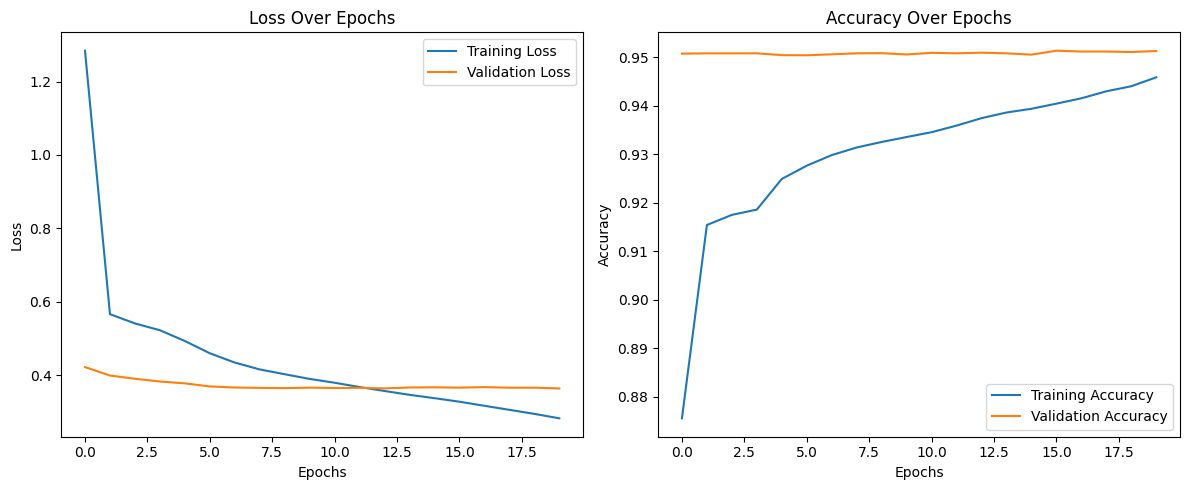

In [16]:
# Plot Loss and Accuracy for Analysis
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Predictions

In [21]:
def translate_sentence(input_sentence, tokenizer_hindi, tokenizer_english, model, max_sequence_length):
    """
    Translates a given Hindi sentence into English using the trained Seq2Seq model.

    Parameters:
    - input_sentence: str, the Hindi sentence to translate.
    - tokenizer_hindi: tokenizer used to process Hindi text.
    - tokenizer_english: tokenizer used to process English text.
    - model: the trained Seq2Seq model.
    - max_sequence_length: int, the maximum sequence length for padding.

    Returns:
    - str, the translated English sentence.
    """
    # Tokenize and pad the input sentence
    input_sequence = tokenizer_hindi.texts_to_sequences([input_sentence])
    input_sequence = pad_sequences(input_sequence, maxlen=max_sequence_length, padding='post')

    # Initialize decoder input with SOS token
    decoder_input = np.zeros((1, max_sequence_length))
    decoder_input[0, 0] = tokenizer_english.word_index[SOS_token]

    translated_sentence = []

    # Iterate through the max sequence length to generate each word
    for i in range(max_sequence_length - 1):
        # Predict the next word
        predictions = model.predict([input_sequence, decoder_input], verbose=0)
        predicted_word_index = np.argmax(predictions[0, i, :])

        # Convert predicted index to word
        predicted_word = {v: k for k, v in tokenizer_english.word_index.items()}.get(predicted_word_index, None)

        if predicted_word == EOS_token or predicted_word is None:
            break

        translated_sentence.append(predicted_word)
        decoder_input[0, i + 1] = predicted_word_index

    return ' '.join(translated_sentence)

# Example usage
hindi_sentence = "आग बबूला होना"
translated_sentence = translate_sentence(hindi_sentence, tokenizer_hindi, tokenizer_english, model, max_sequence_length)
print("Translated Sentence:", translated_sentence)

Translated Sentence: remove the king of spades


# BLUE SCORE

In [22]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calculate_bleu_scores(model, tokenizer_hindi, tokenizer_english, test_data, max_sequence_length):
    """
    Calculate BLEU scores for a set of Hindi-English translation pairs.

    Parameters:
    - model: the trained Seq2Seq model.
    - tokenizer_hindi: tokenizer for Hindi text.
    - tokenizer_english: tokenizer for English text.
    - test_data: DataFrame with 'Hindi Tokens' and 'English Tokens' columns for evaluation.
    - max_sequence_length: maximum sequence length used during training.

    Returns:
    - List of BLEU scores for the test data.
    """
    bleu_scores = []
    smoothing_function = SmoothingFunction().method4

    for _, row in test_data.iterrows():
        # Get input and reference sentences
        hindi_sentence = ' '.join(row['Hindi Tokens'])
        reference_sentence = ' '.join(row['English Tokens'])

        # Generate the prediction
        predicted_sentence = translate_sentence(hindi_sentence, tokenizer_hindi, tokenizer_english, model, max_sequence_length)

        # Tokenize reference and predicted sentences
        reference_tokens = [reference_sentence.split()]
        predicted_tokens = predicted_sentence.split()

        # Compute BLEU score for the sentence
        bleu_score = sentence_bleu(reference_tokens, predicted_tokens, smoothing_function=smoothing_function)
        bleu_scores.append(bleu_score)

    return bleu_scores

# Example usage with a subset of test data
# Assuming `test_df` contains a subset of test data with 'Hindi Tokens' and 'English Tokens'
test_df = df.sample(10)  # Take a small sample for testing BLEU calculation
bleu_scores = calculate_bleu_scores(model, tokenizer_hindi, tokenizer_english, test_df, max_sequence_length)

# Display BLEU scores
for i, score in enumerate(bleu_scores):
    print(f"Sentence {i + 1}: BLEU Score = {score:.4f}")

# Calculate and print the average BLEU score for the test set
average_bleu_score = np.mean(bleu_scores)
print(f"\nAverage BLEU Score: {average_bleu_score:.4f}")


Sentence 1: BLEU Score = 0.0000
Sentence 2: BLEU Score = 0.0000
Sentence 3: BLEU Score = 0.0000
Sentence 4: BLEU Score = 0.0000
Sentence 5: BLEU Score = 0.0000
Sentence 6: BLEU Score = 0.0000
Sentence 7: BLEU Score = 0.0000
Sentence 8: BLEU Score = 0.0000
Sentence 9: BLEU Score = 0.7515
Sentence 10: BLEU Score = 0.0000

Average BLEU Score: 0.0751
